In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from math import sqrt, log, erf
from scipy.stats import norm
from scipy.optimize import brentq
import plotly.graph_objects as go

In [21]:
#Outils

def g(x, a):
    """
    Noyau TBSS applicable au processus de variance rBergomi
    """
    return x**a

def b(k, a):
    """
    Discrétisation optimale du processus TBSS pour minimiser l'erreur hybrid sheme
    """
    return ((k**(a+1)-(k-1)**(a+1))/(a+1))**(1/a)

def cov(a, n):
    """
    Matrice des covariances pour alpha et n donnés, kappa = 1 pour la traçabilité
    """
    cov = np.array([[0.,0.],[0.,0.]])
    cov[0,0] = 1./n
    cov[0,1] = 1./((1.*a+1) * n**(1.*a+1))
    cov[1,1] = 1./((2.*a+1) * n**(2.*a+1))
    cov[1,0] = cov[0,1]
    return cov

def bs(F, K, V, o = 'call'):
    """
    Prix du call B&S à partir de la vol
    """

    w = 1
    if o == 'put':
        w = -1
    elif o == 'otm':
        w = 2 * (K > 1.0) - 1

    sv = np.sqrt(V)
    d1 = np.log(F/K) / sv + 0.5 * sv
    d2 = d1 - sv
    P = w * F * norm.cdf(w * d1) - w * K * norm.cdf(w * d2)
    return P

def bsinv(P, F, K, t, o = 'call'):
    """
    vol implicite à partir du prix B&S
    """

    w = 1
    if o == 'put':
        w = -1
    elif o == 'otm':
        w = 2 * (K > 1.0) - 1

    # Valeur intrinsèque
    P = np.maximum(P, np.maximum(w * (F - K), 0))

    def error(s):
        return bs(F, K, s**2 * t, o) - P
    s = brentq(error, 1e-9, 1e+9)
    return s

In [22]:
#Notre modèle rBergomi

class rBergomi(object):
    """
    Class pour la simulation des chemins Monte Carlo sous rBergomi
    """
    def __init__(self, n = 100, N = 1000, T = 1.00, a = -0.4):
        """
        Constructueur de classe
        """
        self.T = T
        self.n = n
        self.dt = 1.0/self.n
        self.s = int(self.n * self.T)
        self.t = np.linspace(0, self.T, 1 + self.s)[np.newaxis,:]
        self.a = a
        self.N = N

        self.e = np.array([0,0])
        self.c = cov(self.a, self.n)

    def dW1(self):
        """
        Création du mouvement brownien pour le processus de variance
        """
        rng = np.random.multivariate_normal
        return rng(self.e, self.c, (self.N, self.s))

    def Y(self, dW):
        """
        Construire le processus de Volterra ave les incréments Brownien
        """
        Y1 = np.zeros((self.N, 1 + self.s)) # Intégrales exactes
        Y2 = np.zeros((self.N, 1 + self.s)) # Riemann

        # Y1 avec l'intégrle exacte
        for i in np.arange(1, 1 + self.s, 1):
            Y1[:,i] = dW[:,i-1,1] # kappa = 1

        # Arrays pour la convolution (calcul des intégrale de rieman louville)
        G = np.zeros(1 + self.s) # Gamma
        for k in np.arange(2, 1 + self.s, 1):
            G[k] = g(b(k, self.a)/self.n, self.a)

        X = dW[:,:,0] # Xi

        # initialisation du résultat de la convolution
        GX = np.zeros((self.N, len(X[0,:]) + len(G) - 1))

        # Compute de la convolution, on utilise pas la FFT ici mais on pourrait si n grand
        for i in range(self.N):
            GX[i,:] = np.convolve(G, X[i,:])

        # On coupe la convoution pour garder la partie utile
        Y2 = GX[:,:1 + self.s]

        # Construction finale du processus
        Y = np.sqrt(2 * self.a + 1) * (Y1 + Y2)
        return Y

    def dW2(self):
        """
        Incréments orthogonaux
        """
        return np.random.randn(self.N, self.s) * np.sqrt(self.dt)

    def dB(self, dW1, dW2, rho = 0.0):
        """
        Construit les incréments Brownien du prix corrélé (rho) à ceux de la variance, dB.
        """
        self.rho = rho
        dB = rho * dW1[:,:,0] + np.sqrt(1 - rho**2) * dW2
        return dB

    def V(self, Y, xi = 1.0, eta = 1.0):
        """
        Processus de variance rBergomi
        """
        self.xi = xi
        self.eta = eta
        a = self.a
        t = self.t
        V = xi * np.exp(eta * Y - 0.5 * eta**2 * t**(2 * a + 1))
        return V

    def S(self, V, dB, S0 = 1):
        """
        Processus du prix rBergomi
        """
        self.S0 = S0
        dt = self.dt
        rho = self.rho

        # Riemann incréments
        increments = np.sqrt(V[:,:-1]) * dB - 0.5 * V[:,:-1] * dt
        integral = np.cumsum(increments, axis = 1)

        S = np.zeros_like(V)
        S[:,0] = S0
        S[:,1:] = S0 * np.exp(integral)
        return S

    def S1(self, V, dW1, rho, S0 = 1):
        """
        Processus prix parallèle rBergomi
        """
        dt = self.dt

        # Riemann increments
        increments = rho * np.sqrt(V[:,:-1]) * dW1[:,:,0] - 0.5 * rho**2 * V[:,:-1] * dt
        integral = np.cumsum(increments, axis = 1)

        S = np.zeros_like(V)
        S[:,0] = S0
        S[:,1:] = S0 * np.exp(integral)
        return S

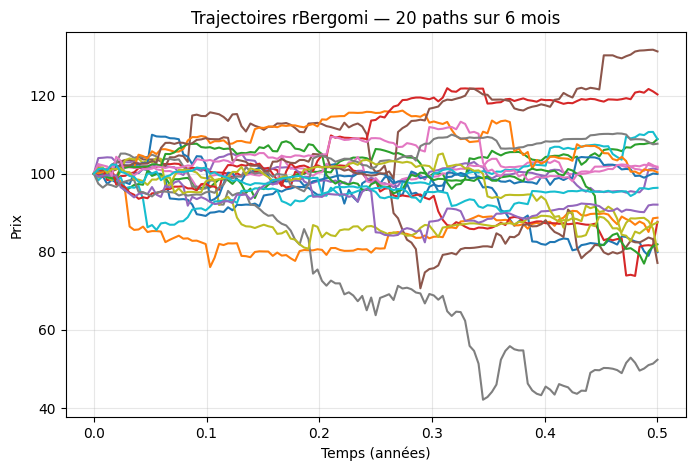

In [33]:
# Visualisation de la simulation de Monte-Carlo

# Paramètres
S0  = 100.0       # prix initial
T   = 6/12        # en année
n   = 252
N   = 20          # nbr de trajectoires

H   = 0.03        # Rugosité de la vol
sigma = 0.25      # niveau vol ATM
eta = 2.0         # vol-of-vol
rho = -0.9        # corrélation prix-vol

a   = H - 0.5     # a = exposant du noyau Rieman-Louville dans notre Mouvement Brownien Fractionaire
xi  = sigma**2

#  Simulation
rB  = rBergomi(n=n, N=N, T=T, a=a)
dW1 = rB.dW1()
Y   = rB.Y(dW1)
V   = rB.V(Y, xi=xi, eta=eta)
dW2 = rB.dW2()
dB  = rB.dB(dW1, dW2, rho=rho)
S   = rB.S(V, dB, S0=S0)

# plot
t = np.linspace(0.0, T, S.shape[1])
plt.figure(figsize=(8,5))
for i in range(N):
    plt.plot(t, S[i, :])
plt.title("Trajectoires rBergomi — 20 paths sur 6 mois")
plt.xlabel("Temps (années)")
plt.ylabel("Prix")
plt.grid(True, alpha=0.3)
plt.show()

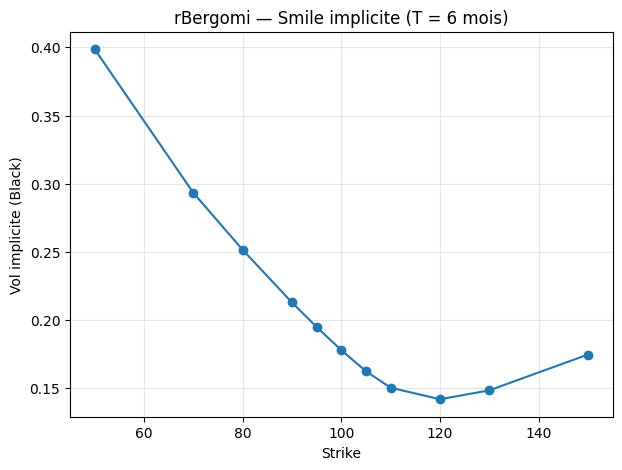

In [31]:
# Smile sous rBergomi

# Paramètres
S0  = 100.0       # prix initial
T   = 6/12        # en année
n   = 252
N   = 100000          # nbr de trajectoires

H   = 0.05        # Rugosité de la vol
sigma = 0.20      # niveau vol ATM
eta = 1.9         # vol-of-vol
rho = -0.9        # corrélation prix-vol

a   = H - 0.5     # a = exposant du noyau Rieman-Louville dans notre Mouvement Brownien Fractionaire
xi  = sigma**2

# --- SIMULATION ---
rB  = rBergomi(n=n, N=N, T=T, a=a)
dW1 = rB.dW1()
Y   = rB.Y(dW1)
V   = rB.V(Y, xi=xi, eta=eta)
dW2 = rB.dW2()
dB  = rB.dB(dW1, dW2, rho=rho)
S   = rB.S(V, dB, S0=S0)

ST = S[:, -1]   # prix à maturité

# Strikes pour notre smile
moneyness = np.array([0.5,0.7, 0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.2, 1.3, 1.5])
strikes   = S0 * moneyness

# Prix MC et vols implicites B&S
F = S0  # r=0 et pas de dividendes dans l'exemple
impvols = []

for K in strikes:
    # prix call MC (non actualisé ici car r=0)
    P = np.maximum(ST - K, 0.0).mean()
    # vol implicite avec bsinv
    sig = bsinv(P, F=F, K=K, t=T, o='call')
    impvols.append(sig)

impvols = np.array(impvols)

# plot
plt.figure(figsize=(7,5))
plt.plot(strikes, impvols, marker='o')
plt.xlabel("Strike")
plt.ylabel("Vol implicite (Black)")
plt.title("rBergomi — Smile implicite (T = 6 mois)")
plt.grid(True, alpha=0.3)
plt.show()

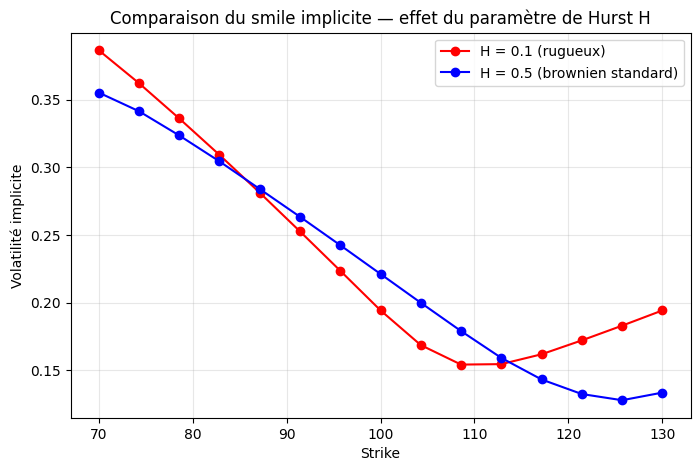

In [35]:
# Comparaison pour comprendre le rough volatility : deux smile avec deux H différents

# --- Paramètres communs ---
T   = 3/12
n   = 252
N   = 50000
sigma = 0.25
eta = 2.5
rho = -0.9
xi  = sigma**2
S0  = 100.0

# Simulation pour deux valeurs de H
H_values = [0.1, 0.49999]  #Ici changer les valeurs de H pour voir l'effet de la rugosité sur le smile/skew
colors   = ['red', 'blue']
labels   = [r'H = 0.1 (rugueux)', r'H = 0.5 (brownien standard)']

# Strikes
moneyness = np.linspace(0.7, 1.3, 15)
strikes   = S0 * moneyness
F = S0

# Stockage des résultats
all_impvols = []

for H in H_values:
    a = H - 0.5

    # Simulation rBergomi
    rB  = rBergomi(n=n, N=N, T=T, a=a)
    dW1 = rB.dW1()
    Y   = rB.Y(dW1)
    V   = rB.V(Y, xi=xi, eta=eta)
    dW2 = rB.dW2()
    dB  = rB.dB(dW1, dW2, rho=rho)
    S   = rB.S(V, dB, S0=S0)
    ST  = S[:, -1]

    # Calcul des vols implicites
    impvols = []
    for K in strikes:
        P = np.maximum(ST - K, 0.0).mean()
        sig = bsinv(P, F=F, K=K, t=T, o='call')
        impvols.append(sig)
    all_impvols.append(impvols)

# Plot
plt.figure(figsize=(8,5))
for impvols, col, lab in zip(all_impvols, colors, labels):
    plt.plot(strikes, impvols, color=col, marker='o', label=lab)

plt.xlabel("Strike")
plt.ylabel("Volatilité implicite")
plt.title("Comparaison du smile implicite — effet du paramètre de Hurst H")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [44]:
#Création d'une surface de vol en 3d avec plotly express pour la visualisation

# Paramètres
S0   = 100.0
n    = 252
N    = 500000
H = 0.129858
eta = 2.497832
rho = -0.818166
sigma = 0.201212

a  = H - 0.5
xi = sigma**2

#Black-Scholes helpers
def bs_call_forward(F, K, var):
    sv = np.sqrt(np.maximum(var, 1e-18))
    d1 = np.log(F/K)/sv + 0.5*sv
    d2 = d1 - sv
    return F*norm.cdf(d1) - K*norm.cdf(d2)

def bsinv_call_forward(P, F, K, T):
    intrinsic = max(F-K, 0.0)
    upper = F
    eps = 1e-12
    if P <= intrinsic + eps:
        return 0.0
    if P >= upper - eps:
        return np.nan
    def err(sig):
        return bs_call_forward(F, K, (sig*sig)*T) - P
    a, b = 1e-12, 5.0
    fa, fb = err(a), err(b)
    if np.sign(fa) == np.sign(fb):
        return np.nan
    return brentq(err, a, b, maxiter=100)

# Simulation conditionnelle
def simulate_surface_iv_conditional(S0, n, N, H, eta, rho, sigma, T_list, strikes):
    """
    Simule un Smile avec notre class rBergomi pour chaque maturité
    """

    IV = np.full((len(T_list), len(strikes)), np.nan, dtype=float)

    for iT, T in enumerate(T_list):
        rB  = rBergomi(n=n, N=N, T=T, a=a)
        dW1 = rB.dW1()
        Y   = rB.Y(dW1)
        V   = rB.V(Y, xi=xi, eta=eta)
        dt  = 1.0 / n
        I   = V[:, :-1].sum(axis=1) * dt
        A   = (np.sqrt(V[:, :-1]) * dW1[:, :, 0]).sum(axis=1)

        F_eff   = S0 * np.exp(rho*A - 0.5*(rho**2)*I)
        Var_eff = (1.0 - rho**2) * I

        for jK, K in enumerate(strikes):
            P = bs_call_forward(F_eff, K, Var_eff).mean()
            IV[iT, jK] = bsinv_call_forward(P, S0, K, T)

    return IV


# Grille de la SVI
T_list = np.array([1/12, 2/12, 3/12, 4/12, 5/12, 6/12])
moneyness = np.array([0.50, 0.60, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95,
                     0.975, 1.00, 1.025, 1.05, 1.10, 1.15, 1.20, 1.25,
                     1.30, 1.40, 1.50])
strikes   = S0 * moneyness

# Simulation
IV = simulate_surface_iv_conditional(S0, n, N, H, eta, rho, sigma, T_list, strikes)

# Plotly 3D
fig = go.Figure(data=[go.Surface(
    x=strikes,
    y=T_list,
    z=100.0*IV,
    colorscale='Jet',
    showscale=True,
    contours = {
        "x": {"show": True, "color":"black", "width":3},
        "y": {"show": True, "color":"black", "width":3},
        "z": {"show": True, "color":"black", "width":3},
    },
    opacity=1
)])
fig.update_layout(
    template='plotly_white',
    scene=dict(
        xaxis_title='K',
        yaxis_title='T',
        zaxis_title='IV',
        zaxis=dict(tickformat='.1f')
    ),

)

fig.show()


Binary Call  K=100% : 0.653171
Binary Call  K=110% : 0.166406
Down-and-In Put  K=60% : 0.200617
Down-and-In Put  K=50% : 0.095932


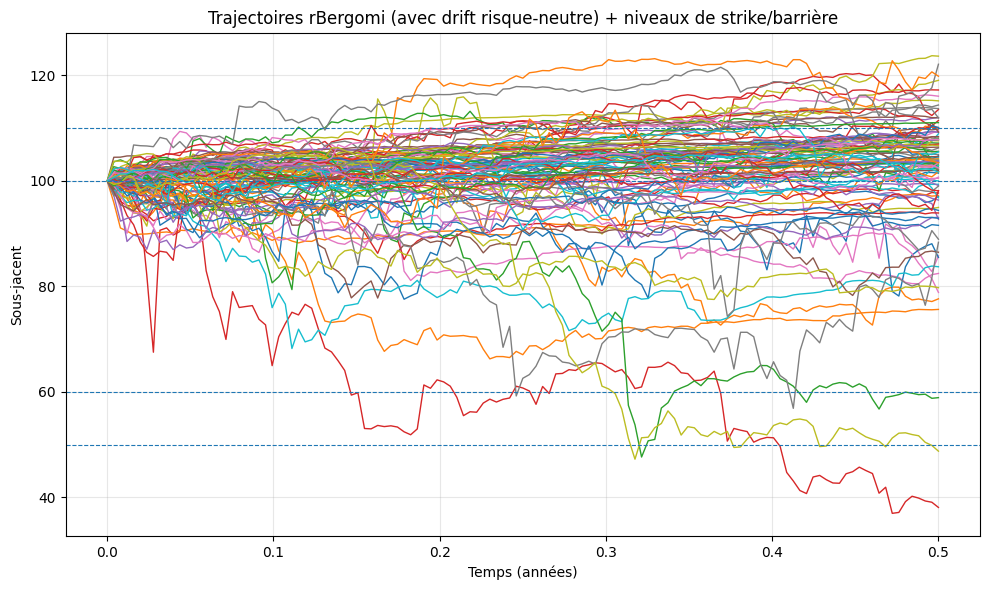

In [45]:
#Pricing d'exotiques (Binaires et PDI) + Visulation pour comprendre le pricing MC

# Paramètres de marché
S0 = 100
r  = 0.0205
q  = 0.0
T  = 6/12     # en année
n  = 252      # pas par an

# Paramètres rBergomi
H   = 0.13
sigma = 0.20
eta = 2.5
rho = -0.82

a   = H - 0.5
xi  = sigma**2

# Monte Carlo
N_paths_price = 50000      # pour le pricing
N_paths_plot  = 100        # à afficher sur le graphe
seed_price    = 42
seed_plot     = 123

# Strikes / Barrières
#Strikes des binaires
K_bin_100 = 1.00 * S0
K_bin_110 = 1.10 * S0

#Strikes des PDI
K_DI_60 = 0.60 * S0;  B_DI_60 = K_DI_60   # Down-and-In Put K=B
K_DI_50 = 0.50 * S0;  B_DI_50 = K_DI_50


# Helpers de simulation
def simulate_paths_rB(N_paths, seed):
    """
    Simule S_t avec ta classe rBergomi (sans drift),
    puis applique le drift risque-neutre en multipliant par exp((r-q)*t).
    Retourne S_Q (avec drift), t (grille des temps).
    """
    # seed pour rendre np.random reproductible
    np.random.seed(seed)

    rb = rBergomi(n=n, N=N_paths, T=T, a=a)
    dW1 = rb.dW1()
    Y   = rb.Y(dW1)
    V   = rb.V(Y, xi=xi, eta=eta)
    dW2 = rb.dW2()
    dB  = rb.dB(dW1, dW2, rho=rho)
    S   = rb.S(V, dB, S0=S0)              # sans drift dans la classe

    # applique le drift risque-neutre (r - q)
    t = np.linspace(0.0, T, S.shape[1])
    drift_factor = np.exp((r - q) * t)[None, :]
    S_Q = S * drift_factor
    return S_Q, t


# Simulation pour pricing

S_price, tgrid = simulate_paths_rB(N_paths_price, seed_price)
S_T   = S_price[:, -1]
S_min = S_price.min(axis=1)

disc = np.exp(-r * T)

# 1) Binaires call (cash-or-nothing, payoff = 1_{S_T >= K})
pay_bin_100 = (S_T >= K_bin_100).astype(float)
pay_bin_110 = (S_T >= K_bin_110).astype(float)

price_bin_100 = disc * pay_bin_100.mean()
price_bin_110 = disc * pay_bin_110.mean()

# 2) Put Down-and-In, payoff = (K - S_T)^+ * 1_{min S <= B}
pay_DI_60 = np.maximum(K_DI_60 - S_T, 0.0) * (S_min <= B_DI_60)
pay_DI_50 = np.maximum(K_DI_50 - S_T, 0.0) * (S_min <= B_DI_50)

price_DI_60 = disc * pay_DI_60.mean()
price_DI_50 = disc * pay_DI_50.mean()

print(f"Binary Call  K=100% : {price_bin_100:.6f}")
print(f"Binary Call  K=110% : {price_bin_110:.6f}")
print(f"Down-and-In Put  K=60% : {price_DI_60:.6f}")
print(f"Down-and-In Put  K=50% : {price_DI_50:.6f}")


# Plot
S_plot, tplot = simulate_paths_rB(N_paths_plot, seed_plot)

plt.figure(figsize=(10,6))
for i in range(min(N_paths_plot, S_plot.shape[0])):
    plt.plot(tplot, S_plot[i, :], linewidth=1)

# Affichage des strikes sur le graph
for y in [K_bin_100, K_bin_110, K_DI_60, K_DI_50]:
    plt.axhline(y, linestyle='--', linewidth=0.8)

plt.xlabel("Temps (années)")
plt.ylabel("Sous-jacent")
plt.title("Trajectoires rBergomi (avec drift risque-neutre) + niveaux de strike/barrière")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
